In [111]:
import numpy as np
import matplotlib.pyplot as plt

In [112]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import splu

from scipy.special import gammaincc, gamma, gammainc, expi

def potential_theoretical_gaussian(X, Y, sigma):
    # Constants
    pi = np.pi
    r = np.sqrt(X**2 + Y**2)
    # Calculate the potential
    term1 = -1 / (2 * pi) * np.log(r)
    # term2 = -1 / (2 * pi) * 0.5 * gammaincc(0, r**2 / (2 * sigma**2))
    term2 = -1 / (2 * pi) * 0.5 * (-expi(-r**2 / (2 * sigma**2)))

    return term1 + term2

def assemble_poisson_matrix_noperm(nrows, ncols, hx, hy):
    A = lil_matrix((nrows * ncols, nrows * ncols))

    for i in range(nrows):
        for j in range(ncols):
            k = i * ncols + j

            if i == 0 or i == nrows - 1 or j == 0 or j == ncols - 1:
                A[k, k] = 1  # Modify diagonal for Dirichlet BC
                continue

            A[k, k] = -2 / hx**2 - 2 / hy**2
            
            # if j + 1 < ncols:
            A[k, k + 1] = 1 / hx**2

            # if j - 1 >= 0:
            A[k, k - 1] = 1 / hx**2

            # if i + 1 < nrows:
            A[k, k + ncols] = 1 / hy**2

            # if i - 1 >= 0:
            A[k, k - ncols] = 1 / hy**2

    A = A.tocsc()
    lu_A = splu(A)

    return lu_A

In [113]:
def assemble_poisson_matrix(nrows, ncols, hx, hy, eps_in):
    A = lil_matrix((nrows * ncols, nrows * ncols))
    eps = eps_in.ravel()[:]
    for i in range(nrows):
        for j in range(ncols):
            k = i * ncols + j

            if i == 0 or i == nrows - 1 or j == 0 or j == ncols - 1:
                A[k, k] = 1  # Modify diagonal for Dirichlet BC
                continue

            A[k, k] = - 0.5 * (eps[k-1] + eps[k+1] + 2 * eps[k]) / hx**2  - 0.5 * (eps[k-ncols] + eps[k+ncols] + 2 * eps[k]) / hy**2
            
            # if j + 1 < ncols:
            A[k, k + 1] = 1 / hx**2 * (eps[k] + eps[k+1]) * 0.5

            # if j - 1 >= 0:
            A[k, k - 1] = 1 / hx**2 * (eps[k] + eps[k-1]) * 0.5

            # if i + 1 < nrows:
            A[k, k + ncols] = 1 / hy**2 * (eps[k] + eps[k+ncols]) * 0.5

            # if i - 1 >= 0:
            A[k, k - ncols] = 1 / hy**2 * (eps[k] + eps[k-ncols]) * 0.5

    A = A.tocsc()
    lu_A = splu(A)

    return lu_A

In [129]:
%matplotlib inline

xmin = -10
xmax = 10
ymin = -20
ymax = 20
npx = 100
npy = 200

x = np.linspace(xmin, xmax, npx)
y = np.linspace(ymin, ymax, npy)

hx = x[2] - x[1]
hy = y[2] - y[1]

X, Y = np.meshgrid(x, y)
eps = np.ones_like(X)
eps[X > 0] *= 12


nrows, ncols = np.shape(X) 
lu_a = assemble_poisson_matrix(nrows, ncols, hx, hy, eps)



In [144]:

sigma = 0.5
rho = np.exp(-((X-5)**2 + Y**2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)
rho[X<0] = 0
rho[:,0] = 0
rho[0,:] = 0
rho[-1,:] = 0
rho[:,-1] = 0

b = -rho.ravel()[:]

phi = lu_a.solve(b)
phi = phi.reshape(X.shape)

phi_theory = potential_theoretical_gaussian(X, Y, sigma)

Ey, Ex = np.gradient(-phi, hy, hx)
Ey_theory, Ex_theory = np.gradient(-phi_theory, hy, hx)



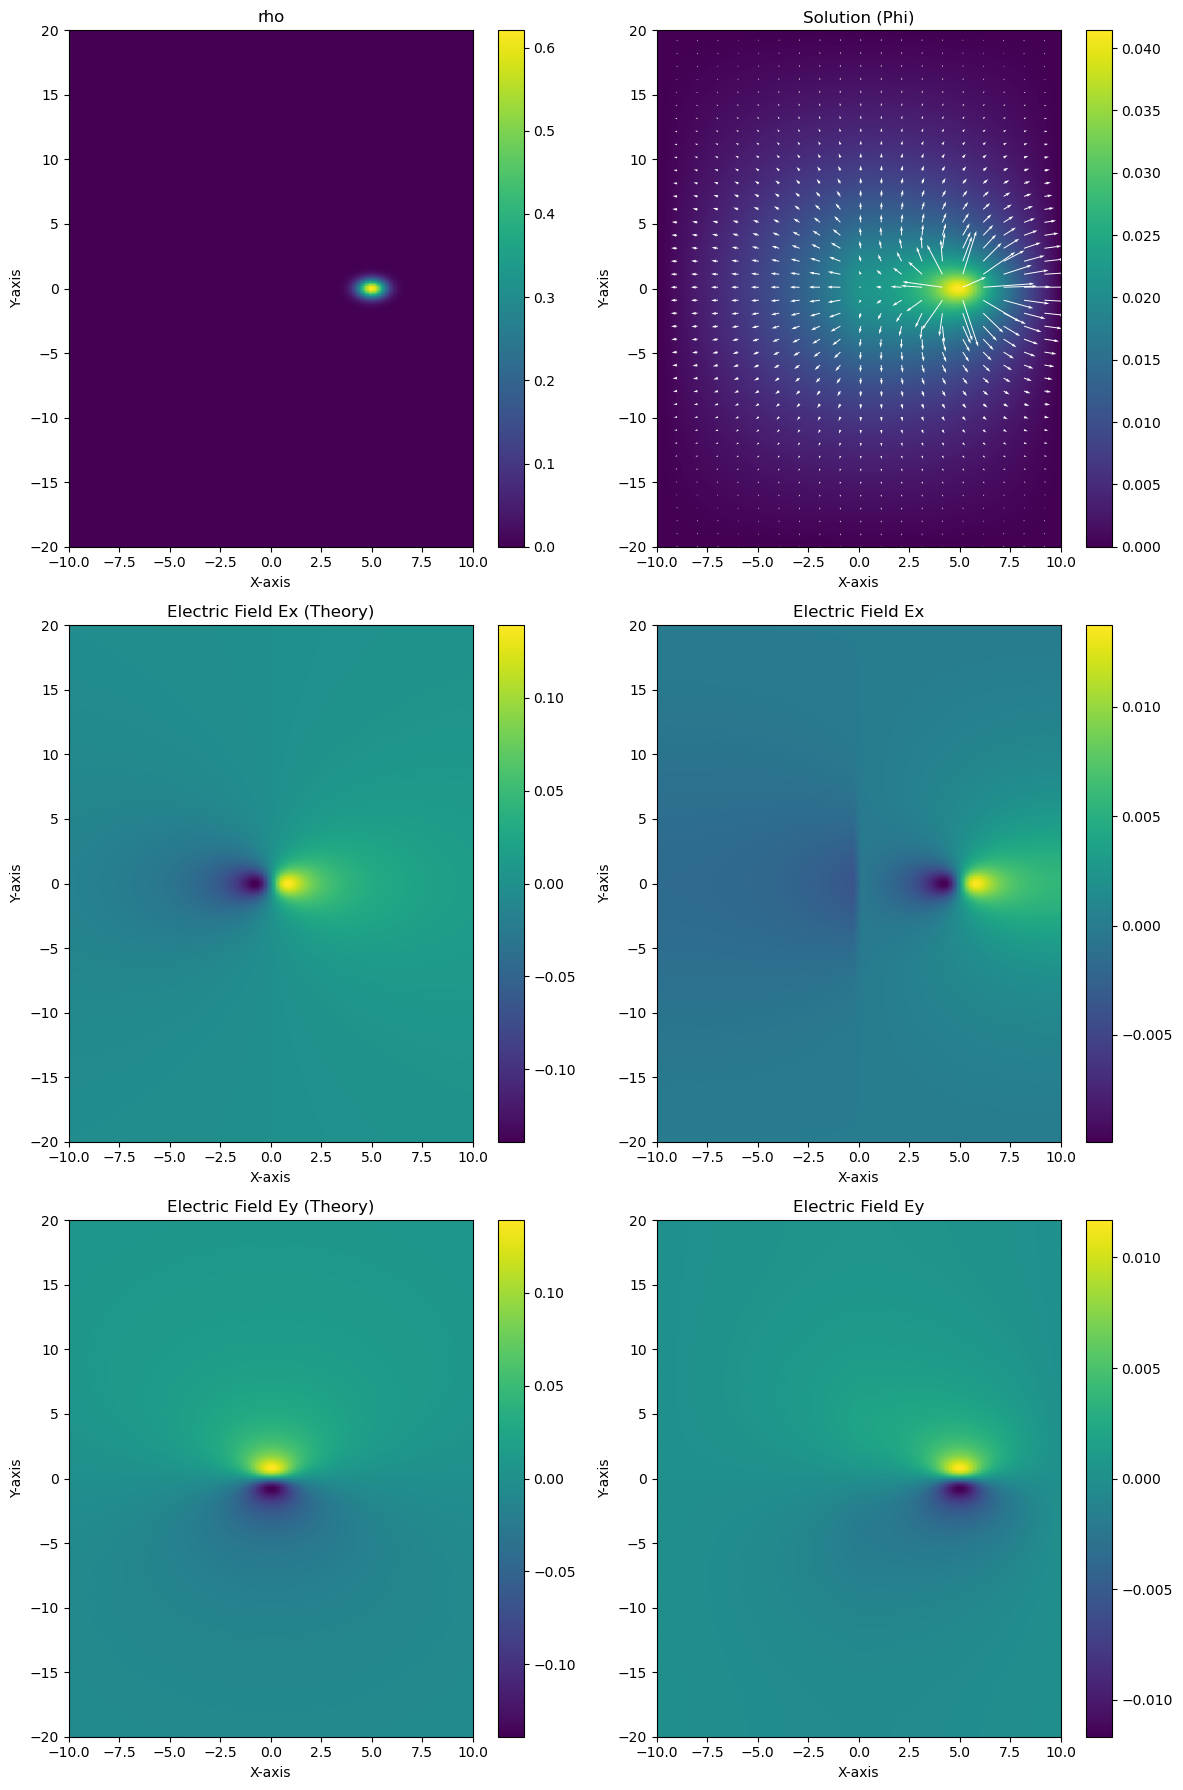

In [148]:
%matplotlib inline
step = 5
# Create a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

# Plot phi_theory
c1 = axs[0, 0].imshow(rho, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect = 'auto')
axs[0, 0].set_title('rho')
axs[0, 0].set_xlabel('X-axis')
axs[0, 0].set_ylabel('Y-axis')
fig.colorbar(c1, ax=axs[0, 0])

# Plot phi
c2 = axs[0, 1].imshow(phi, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect = 'auto')
axs[0, 1].quiver(X[::step, ::step], Y[::step, ::step], Ex[::step, ::step], Ey[::step, ::step], 
                 color='white', scale=.1)
axs[0, 1].set_title('Solution (Phi)')
axs[0, 1].set_xlabel('X-axis')
axs[0, 1].set_ylabel('Y-axis')
fig.colorbar(c2, ax=axs[0, 1])

# Plot Ex_theory
c3 = axs[1, 0].imshow(Ex_theory, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect = 'auto')
axs[1, 0].set_title('Electric Field Ex (Theory)')
axs[1, 0].set_xlabel('X-axis')
axs[1, 0].set_ylabel('Y-axis')
fig.colorbar(c3, ax=axs[1, 0])

# Plot Ex
c4 = axs[1, 1].imshow(Ex, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect = 'auto')
axs[1, 1].set_title('Electric Field Ex')
axs[1, 1].set_xlabel('X-axis')
axs[1, 1].set_ylabel('Y-axis')
fig.colorbar(c4, ax=axs[1, 1])

# Plot Ey_theory
c5 = axs[2, 0].imshow(Ey_theory, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect = 'auto')
axs[2, 0].set_title('Electric Field Ey (Theory)')
axs[2, 0].set_xlabel('X-axis')
axs[2, 0].set_ylabel('Y-axis')
fig.colorbar(c5, ax=axs[2, 0])

# Plot Ey
c6 = axs[2, 1].imshow(Ey, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect = 'auto')
axs[2, 1].set_title('Electric Field Ey')
axs[2, 1].set_xlabel('X-axis')
axs[2, 1].set_ylabel('Y-axis')
fig.colorbar(c6, ax=axs[2, 1])

plt.tight_layout()
plt.show()


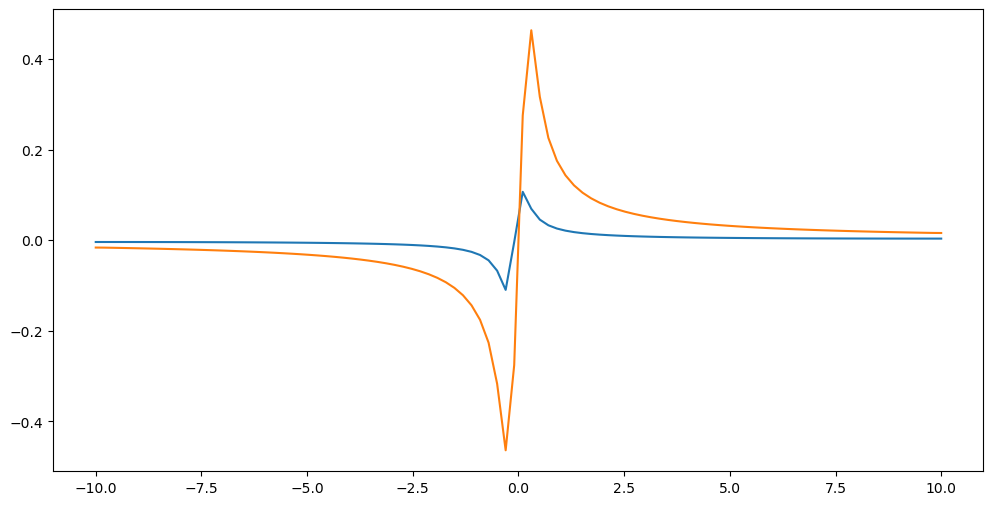

In [120]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x, Ex[nrows//2, :])
plt.plot(x, Ex_theory[nrows//2, :])


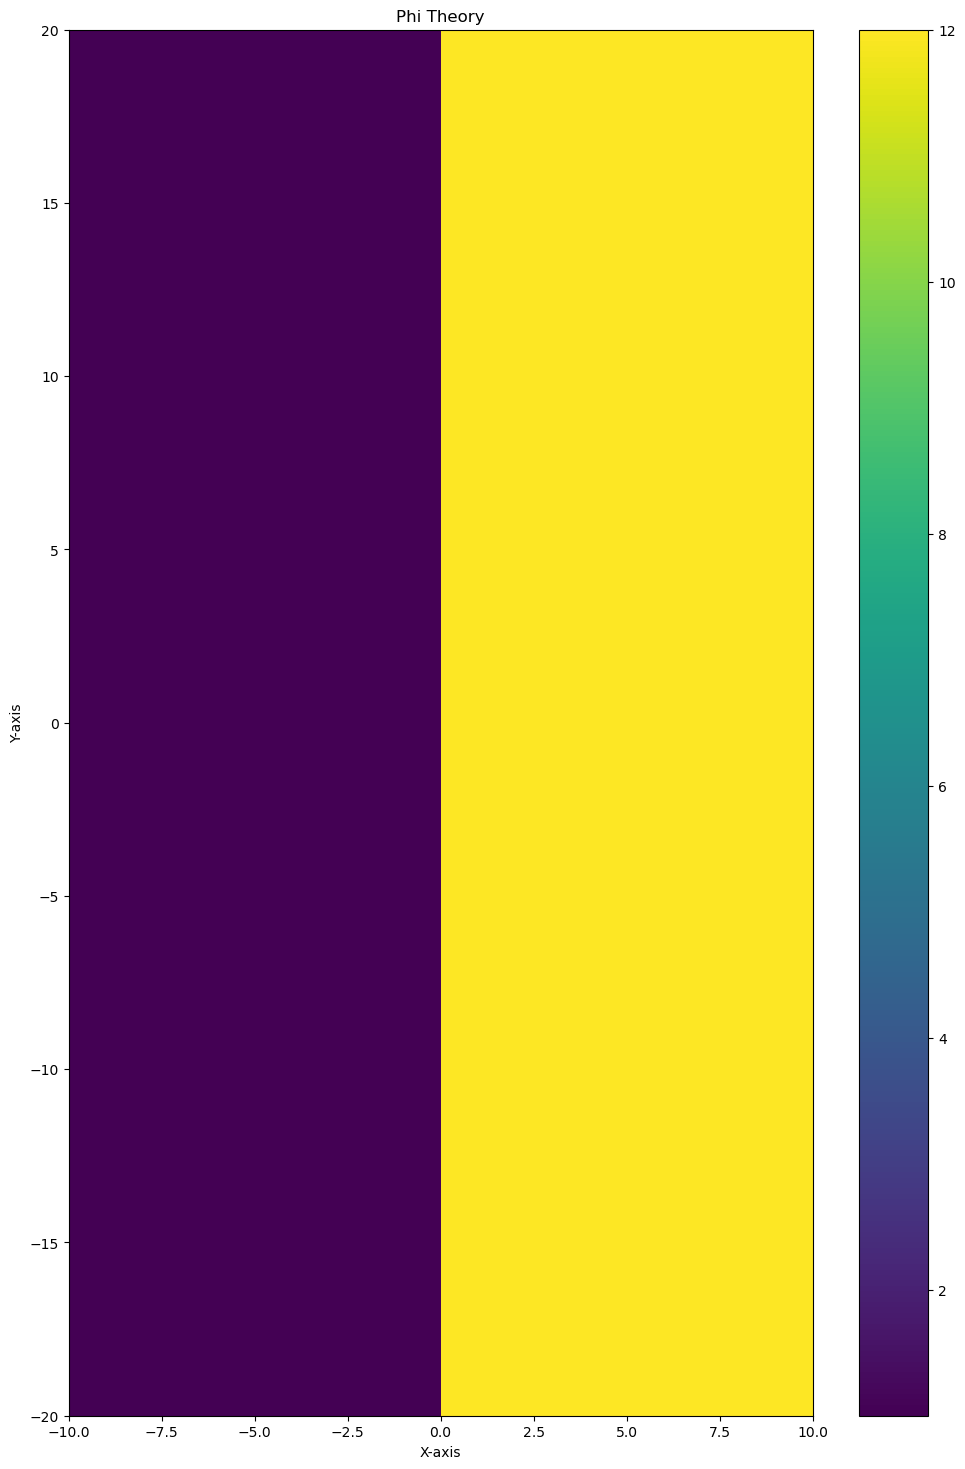

In [125]:
fig, axs = plt.subplots(1, 1, figsize=(12, 18))

# Plot phi_theory
c1 = axs.imshow(eps, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect = 'auto')
axs.set_title('Phi Theory')
axs.set_xlabel('X-axis')
axs.set_ylabel('Y-axis')
fig.colorbar(c1, ax=axs)